# Restaurant Clustering using Population and Foursquare data for Chennai city

The notebook is to perform restaurant clustering for Chennai city using Foursquare and population data. Refer the github for the complete write-up about the project.<br><br>
Report Githublink:https://github.com/prabhakaranelangovan/Coursera_Capstone/blob/master/Restaurant%20Venues%20Clustering%20using%20Foursquare.pdf

In [2]:
#import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

!pip install folium
import folium

     |████████████████████████████████| 92kB 6.7MB/s eta 0:00:011


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
!pip install geocoder
import geocoder

     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011


In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
#Loading chennai city population data collected from govt of india website
ch_population = pd.read_csv(body)

ch_population.rename(columns={'Area':'Location'}, inplace=True)
ch_population.head()

,Ward No,Location,Total Houeholds,Population,Male Population,Female Population,Kids Population,Educated Population,Working Population
0,1,Kodungaiyur (West),18900,76760,38805,37955,8209,63354,29282
1,2,Kodungaiyur (East),16713,66897,33781,33116,7196,54439,25368
2,3,Dr.Radhakrishnan Nagar (North),13248,52995,26804,26191,6326,40119,19429
3,4,Cherian Nagar (North),3634,15186,7506,7680,1564,11579,5176
4,5,Jeeva Nagar (North),11147,45204,22583,22621,4707,34811,17155


In [10]:
#Creating a list of locations for which the location coordinates are required.
locations_list = ch_population['Location'].to_list()

In [11]:
#Getting location coordinates using geocoder 

longitude = []
latitude = []

for locations in locations_list:
    
    # initialize the variable to None
    lat_lng_coords = None

    # loop until getting the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chennai, Tamil Nadu'.format(locations))
        lat_lng_coords = g.latlng

    
    # Append the data to the lists
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

In [12]:
#Creating a merged dataframe containing the locations and the respective coordinates
chennai_loc = pd.DataFrame({'Location':locations_list, 'Latitude':latitude, 'Longitude':longitude})

In [13]:
#Merging the population data with the location data with location as the key for join
chennai_loc = chennai_loc.join(ch_population.set_index('Location'), on = 'Location')

In [14]:
chennai_loc.head()

,Location,Latitude,Longitude,Ward No,Total Houeholds,Population,Male Population,Female Population,Kids Population,Educated Population,Working Population
0,Kodungaiyur (West),13.13663,80.24479,1,18900,76760,38805,37955,8209,63354,29282
1,Kodungaiyur (East),13.13663,80.24479,2,16713,66897,33781,33116,7196,54439,25368
2,Dr.Radhakrishnan Nagar (North),13.12476,80.28526,3,13248,52995,26804,26191,6326,40119,19429
3,Cherian Nagar (North),13.13878,80.29776,4,3634,15186,7506,7680,1564,11579,5176
4,Jeeva Nagar (North),13.11530,80.11434,5,11147,45204,22583,22621,4707,34811,17155


### Some locations have similar coordinates, as the area is classified by govt based on directions.<br>
Need to find those location values and remove the direction names from the names.

In [15]:
#the list contains the location values that need to be replaced.
location_trimlist = chennai_loc[chennai_loc['Location'].str.contains(r'\)')]['Location'].to_list()

In [16]:
#Removing the direction values from the location names and creating a list of new location name values
new_names = []
for old_name in location_trimlist:
    if old_name.endswith('(North)'):
        new_names.append(old_name[:-(len('(North)'))])
    if old_name.endswith('(West)'):
        new_names.append(old_name[:-(len('(West)'))])
    if old_name.endswith('(South)'):
        new_names.append(old_name[:-(len('(South)'))])
    if old_name.endswith('(East)'):
        new_names.append(old_name[:-(len('(East)'))])
    if old_name.endswith('(Central)'):
        new_names.append(old_name[:-(len('(Central)'))])

In [17]:
#replacing the old location names with the new location names
chennai_loc = chennai_loc.replace(location_trimlist,new_names)

In [18]:
#after replacing the values, now the columns will contain duplicate location names.
#Need to merge these duplicate rows into 1 row with population details summed up and lat,long to be excluded from the sum function.
#Example, Anna nagar(West), Anna Nagar will now be two rows with value as Anna Nagar. we are grouping by the location names and applying sum function for 
#all the columns except lat and long columns.
chennai_loc = chennai_loc.groupby('Location', as_index=False).agg({
    'Latitude':'first',
    'Longitude':'first',
    'Ward No': np.sum,
    'Total Houeholds':np.sum,
    'Population':np.sum,
    'Male Population':np.sum,
    'Female Population':np.sum,
    'Kids Population':np.sum,
    'Educated Population':np.sum,
    'Working Population':np.sum,
})

In [19]:
#Noe the loc df contains the location, along with coordinates and population data.
chennai_loc.head()

,Location,Latitude,Longitude,Ward No,Total Houeholds,Population,Male Population,Female Population,Kids Population,Educated Population,Working Population
0,Adikesavapuram,13.054431,80.199095,79,4628,19748,9870,9878,2065,15393,7466
1,Adyar,13.003050,80.251930,303,16323,60216,29805,30411,4994,51963,25497
2,Agaram,13.109530,80.232360,104,23363,90585,45033,45552,8566,77360,34988
3,Alwarpet,13.034710,80.254160,231,12506,48399,23963,24436,4542,38932,20448
4,Aminjikarai,13.071390,80.222560,222,35735,139748,70424,69324,15120,115648,55034


### Using Foursquare API to get location wise venue details

In [20]:
CLIENT_ID = 'JVWMFQTWBJGJBHTGLFCSIDMAM2ARZMAJOFHY5DLVXAUMBNRG' 
CLIENT_SECRET = 'PEQHD2KBLGXN3LZ3KJ0Q1WR2VLXCXJF4NYRFPCDWIQS5AOXE' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JVWMFQTWBJGJBHTGLFCSIDMAM2ARZMAJOFHY5DLVXAUMBNRG
CLIENT_SECRET:PEQHD2KBLGXN3LZ3KJ0Q1WR2VLXCXJF4NYRFPCDWIQS5AOXE


In [21]:
#defining a custom function to take location co-ordinates, prepare URI and to get response from Foursquare.
#getting the venue details in 1000 mtrs radius and add it to venues list. Create and pass a dataframe using that list.
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    limit = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
           
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
#calling the get nearby venues function to get the dataframe containing venue details of chennai city
chennai_venues = getNearbyVenues(
    chennai_loc['Location'],
    chennai_loc['Latitude'],
    chennai_loc['Longitude']
)

chennai_venues.head()

,Location,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adikesavapuram,13.054431,80.199095,Murugan Idli Shop,13.048336,80.205013,Indian Restaurant
1,Adikesavapuram,13.054431,80.199095,Subway,13.047275,80.194957,Sandwich Place
2,Adikesavapuram,13.054431,80.199095,Shoppers Stop Saligramam,13.047779,80.198671,Clothing Store
3,Adikesavapuram,13.054431,80.199095,Domino's Pizza,13.054000,80.207000,Pizza Place
4,Adikesavapuram,13.054431,80.199095,Café Coffee Day,13.047412,80.195252,Café


In [23]:
print('Foursquare returned {} venues for all locations in Chennai'.format(chennai_venues.shape[0]))

Foursquare returned 2216 venues for all locations in Chennai


In [24]:
#the venues returned by foursquare may contain duplicate data as we are getting venues within 1000 mtrs radius, possible that the venue might be listed 
#in multiple locations. To find the duplicates, creating a new column temp with venue+venuelatitude value. if this column contains 
#duplicate values then it must be addressed.
chennai_venues['temp'] = chennai_venues['Venue']+chennai_venues['Venue Latitude'].apply(str)

print('We found that there are {} duplicate entries in the venue data'.format(len(chennai_venues[chennai_venues['temp'].duplicated()]['Venue'])))

chennai_venues.drop_duplicates(subset ="temp", keep = 'first', inplace=True)

chennai_venues.drop('temp', axis=1, inplace=True)

print('{} venues are available after removing duplicate entries'.format(chennai_venues.shape[0]))

We found that there are 900 duplicate entries in the venue data
1316 venues are available after removing duplicate entries


In [25]:
#finding the total number of venue categories listed in chennai city
venue_cat_list = (chennai_venues.groupby(['Location','Venue Category'], as_index=False).count())['Venue Category'].value_counts()
venue_cat_df = pd.DataFrame(venue_cat_list).reset_index().rename(columns={'index':'Venue Category', 'Venue Category':'Count'})

print('Total No of Venue Categories available in Chennai are {}'.format(venue_cat_df.shape[0]))

Total No of Venue Categories available in Chennai are 171


In [26]:
#finding the top 10 venue category in chennai
top_10_ven_cat = venue_cat_df.head(10)
top_10_ven_cat

,Venue Category,Count
0,Indian Restaurant,51
1,Pizza Place,32
2,Café,30
3,Department Store,27
4,Fast Food Restaurant,26
5,Bakery,26
6,Hotel,25
7,Coffee Shop,24
8,Ice Cream Shop,22
9,Vegetarian / Vegan Restaurant,21


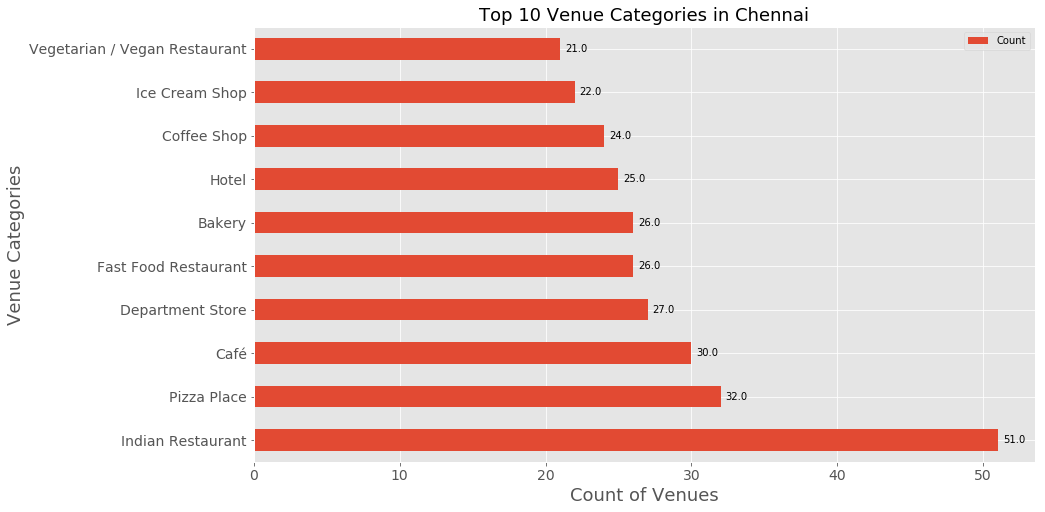

In [48]:
#Top 10 Venue Categories - horizontal bar
ax = top_10_ven_cat.plot(kind='barh',x='Venue Category', figsize=(14,8),fontsize=14)

plt.title('Top 10 Venue Categories in Chennai',fontsize=18)
plt.ylabel('Venue Categories',fontsize=18)
plt.xlabel('Count of Venues',fontsize=18)

for rect in ax.patches:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
plt.show()

In [44]:
#finding the top 10 areas having most number of venues
top_10_areas = chennai_venues.groupby(
    'Location', as_index=False).count()[['Location','Venue Category']].sort_values(
    by='Venue Category', ascending=False, axis=0).rename(
    columns={'Venue Category':'Venue counts'}).reset_index(drop=True)
top_10_areas = top_10_areas.head(10)

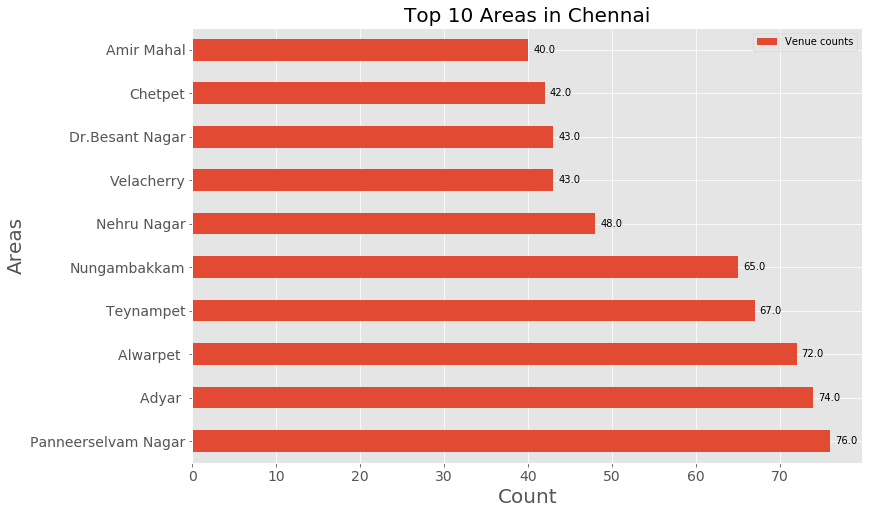

In [64]:
#Top 10 Ares - Horizontal Bar Chart
ax = top_10_areas.plot(kind='barh',x='Location', figsize=(12,8),fontsize=14)

plt.title('Top 10 Areas in Chennai',fontsize=20)
plt.xlabel('Count',fontsize=20)
plt.ylabel('Areas',fontsize=20)

for rect in ax.patches:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.            
plt.show()

In [65]:
#finding the restaurant category counts in chennai
restaurant_count = venue_cat_df[venue_cat_df['Venue Category'].str.contains(r'Restaurant|Pizza|Resto|Coffee|Cafe|Ice|Bakery|Bar|Buffet|Cafeteria|Chocolate Shop|Deli / Bodega|Diner|Food Court|Gourmet Shop|Hookah Bar|Lounge|Pub|Sports Bar|Whisky Bar', case=False)].reset_index(drop=True)

In [66]:
print('Total number of restaurants in chennai as per Foursquare Data is {}'.format(sum(restaurant_count['Count'])))

Total number of restaurants in chennai as per Foursquare Data is 418


In [67]:
print('There are {} different types of restaurants in Chennai'.format(len(restaurant_count['Venue Category'])))

There are 61 different types of restaurants in Chennai


## Feature Selection <br>
Out of 171 Venue categories selecting 98, that are either a restaurant or linked to consumer entertainment spends.

In [68]:
#Feature selection - filtering out unnecessary features
filtered_venues = chennai_venues[chennai_venues['Venue Category'].str.contains(r'Restaurant|Pizza|Resto|Coffee|Cafe|Ice|\
                                                                               Bakery|Amphitheater|Bar|BBQ Joint|Beach|Bistro|\
                                                                               Bowling Alley|Breakfast Spot|Buffet|Burger Joint|\
                                                                               Cafeteria|Chaat Place|Chocolate Shop|Cocktail Bar|\
                                                                               Deli / Bodega|Dessert Shop|Diner|Donut Shop|Food Court|\
                                                                               Fried Chicken Joint|General Entertainment|Golf Course|\
                                                                               Gourmet Shop|Harbor / Marina|Historic Site|Hockey Arena|\
                                                                               Hookah Bar|Hotel Bar|Hotel|Indian Sweet Shop|Indie Movie Theater|\
                                                                               Juice Bar|Lounge|Market|Memorial Site|Motel|Movie Theater|\
                                                                               Multiplex|Museum|Music Venue|National Park|Nightclub|Park|\
                                                                               Performing Arts Venue|Pub|Sandwich Place|Scenic Lookout|\
                                                                               Shopping Mall|Shopping Plaza|Snack Place|Soccer Stadium|Spa|\
                                                                               Sports Bar|Steakhouse|Tennis Stadium|Theater|Whisky Bar',
                                                                               case=False)].reset_index(drop=True)

filtered_venues.head()

,Location,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adikesavapuram,13.054431,80.199095,Murugan Idli Shop,13.048336,80.205013,Indian Restaurant
1,Adikesavapuram,13.054431,80.199095,Subway,13.047275,80.194957,Sandwich Place
2,Adikesavapuram,13.054431,80.199095,Domino's Pizza,13.054000,80.207000,Pizza Place
3,Adikesavapuram,13.054431,80.199095,Pizza Hut,13.047602,80.196430,Pizza Place
4,Adikesavapuram,13.054431,80.199095,Copper kitchen,13.050681,80.203914,Indian Restaurant


In [69]:
print('Out of {} venues, {} venues are selected for analysis.'.format(chennai_venues.shape[0],filtered_venues.shape[0]))

Out of 1316 venues, 898 venues are selected for analysis.


In [70]:
print('Out of {} venue categories, {} venue categories are selected for analysis.'.format(
    len(chennai_venues['Venue Category'].unique()),
    len(filtered_venues['Venue Category'].unique())))

Out of 171 venue categories, 98 venue categories are selected for analysis.


## Converting Venue Categories to continuous variable by one hot encoding as the classes are huge hence label encoder wont come in handy.

In [71]:
#venue category is one hot encoded 
ven_cat_onehot = pd.get_dummies(filtered_venues[['Venue Category']],prefix='',prefix_sep='')
ven_cat_onehot['Location'] = filtered_venues['Location']
ven_cat_onehot['Total Venues'] = ven_cat_onehot.sum(axis=1)

#the order of the columns changed because of getdummies, rearranging them.
fixed_col = [ven_cat_onehot.columns[-1]]+list(ven_cat_onehot.columns[:-1])
ven_cat_onehot = ven_cat_onehot[fixed_col]

fixed_col = [ven_cat_onehot.columns[-1]]+list(ven_cat_onehot.columns[:-1])
ven_cat_onehot = ven_cat_onehot[fixed_col]

ven_cat_onehot.head()

,Location,Total Venues,African Restaurant,American Restaurant,Amphitheater,Andhra Restaurant,Asian Restaurant,BBQ Joint,Bar,Beach,...,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tennis Stadium,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adikesavapuram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adikesavapuram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adikesavapuram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adikesavapuram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adikesavapuram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Grouping the one hot encoded by location
venues_grouped = ven_cat_onehot.groupby('Location').sum().reset_index()
venues_grouped.head()

,Location,Total Venues,African Restaurant,American Restaurant,Amphitheater,Andhra Restaurant,Asian Restaurant,BBQ Joint,Bar,Beach,...,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tennis Stadium,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adikesavapuram,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adyar,51,0,0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Agaram,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alwarpet,51,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,2,0,1,0
4,Aminjikarai,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#Creating a final cleaned data df before passing on to the model
chennai_processed = venues_grouped.join(chennai_loc.set_index('Location'), on = 'Location',how='left')
chennai_processed.head()

,Location,Total Venues,African Restaurant,American Restaurant,Amphitheater,Andhra Restaurant,Asian Restaurant,BBQ Joint,Bar,Beach,...,Latitude,Longitude,Ward No,Total Houeholds,Population,Male Population,Female Population,Kids Population,Educated Population,Working Population
0,Adikesavapuram,6,0,0,0,0,0,0,0,0,...,13.054431,80.199095,79,4628,19748,9870,9878,2065,15393,7466
1,Adyar,51,0,0,0,0,3,1,0,0,...,13.003050,80.251930,303,16323,60216,29805,30411,4994,51963,25497
2,Agaram,1,0,0,0,0,0,0,0,0,...,13.109530,80.232360,104,23363,90585,45033,45552,8566,77360,34988
3,Alwarpet,51,0,0,0,0,0,0,1,0,...,13.034710,80.254160,231,12506,48399,23963,24436,4542,38932,20448
4,Aminjikarai,9,0,0,0,0,0,0,0,0,...,13.071390,80.222560,222,35735,139748,70424,69324,15120,115648,55034


In [74]:
#dropping unwanted columns that may impact the modeling performance
chennai_processed.drop(['Latitude','Longitude','Ward No','Male Population','Female Population'],axis=1,inplace=True)

fixed_col = [chennai_processed.columns[0]]+list(chennai_processed.columns[-5:])+list(chennai_processed.columns[1:-5])
chennai_processed = chennai_processed[fixed_col]
chennai_processed.head()

,Location,Total Houeholds,Population,Kids Population,Educated Population,Working Population,Total Venues,African Restaurant,American Restaurant,Amphitheater,...,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tennis Stadium,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Whisky Bar
0,Adikesavapuram,4628,19748,2065,15393,7466,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adyar,16323,60216,4994,51963,25497,51,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Agaram,23363,90585,8566,77360,34988,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alwarpet,12506,48399,4542,38932,20448,51,0,0,0,...,1,1,0,0,0,0,2,0,1,0
4,Aminjikarai,35735,139748,15120,115648,55034,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
#preparing the final df that is to be passed into the model
chennai_clustering = chennai_processed.drop(['Location'],1)
chennai_clustering.head()

,Total Houeholds,Population,Kids Population,Educated Population,Working Population,Total Venues,African Restaurant,American Restaurant,Amphitheater,Andhra Restaurant,...,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tennis Stadium,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Whisky Bar
0,4628,19748,2065,15393,7466,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16323,60216,4994,51963,25497,51,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,23363,90585,8566,77360,34988,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12506,48399,4542,38932,20448,51,0,0,0,0,...,1,1,0,0,0,0,2,0,1,0
4,35735,139748,15120,115648,55034,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
#changing the df into array
X = chennai_clustering[chennai_clustering.columns].values
X

array([[ 4628, 19748,  2065, ...,     0,     0,     0],
       [16323, 60216,  4994, ...,     0,     1,     0],
       [23363, 90585,  8566, ...,     0,     0,     0],
       ...,
       [ 3134, 12954,  1027, ...,     0,     0,     0],
       [17832, 73886,  8101, ...,     0,     0,     0],
       [ 3452, 14375,  1419, ...,     0,     0,     0]])

In [88]:
#Standardizing the feature matrix 
X = StandardScaler().fit(X).transform(X)
X

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.6385922 , -0.62845433, -0.55719502, ..., -0.18677184,
        -0.47329623, -0.10660036],
       [ 0.59117517,  0.47852173,  0.19930832, ..., -0.18677184,
         0.88552198, -0.10660036],
       [ 1.33145411,  1.30924615,  1.12188597, ..., -0.18677184,
        -0.47329623, -0.10660036],
       ...,
       [-0.79569117, -0.81429982, -0.82529009, ..., -0.18677184,
        -0.47329623, -0.10660036],
       [ 0.74985144,  0.85245577,  1.00178558, ..., -0.18677184,
        -0.47329623, -0.10660036],
       [-0.76225243, -0.77542928, -0.72404417, ..., -0.18677184,
        -0.47329623, -0.10660036]])

## Passing the feature matrix to k-means algorithm and obtaining results

In [96]:
no_clusters = 3
# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=no_clusters, random_state=3, n_init=30).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 2, 1, 0, 0, 0, 1, 0], dtype=int32)

In [97]:
#Custom function to return most common 'n' venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[7:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
#obtaining 5 most common venues for each location
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
common_venues = pd.DataFrame(columns=columns)
common_venues['Location'] = chennai_processed['Location']

for ind in np.arange(chennai_processed.shape[0]):
    common_venues.iloc[ind, 1:] = return_most_common_venues(chennai_processed.iloc[ind, :], num_top_venues)

common_venues.head(2)

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adikesavapuram,Indian Restaurant,Pizza Place,Sandwich Place,Whisky Bar,Golf Course
1,Adyar,Indian Restaurant,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Asian Restaurant


## Preparing a final df which displays the cluster labels along with useful information that can help in studying about the clusters and cluster member characteristics

In [152]:
#copying the pre model df to final df
chennai_final = chennai_processed.copy(deep=True)

#inserting a new column for CLuster labels
chennai_final.insert(0, 'Cluster Labels', kmeans.labels_)

#Changing kids, educated, working population values into percentage of total population of that location
chennai_final['Kids Population in %'] = ((chennai_processed['Kids Population']/chennai_processed['Population'])*100).map('{:.2f}'.format).astype('float64')
chennai_final['Educated Population in %'] = ((chennai_processed['Educated Population']/chennai_processed['Population'])*100).map('{:.2f}'.format).astype('float64')
chennai_final['Working Population in %'] = ((chennai_processed['Working Population']/chennai_processed['Population'])*100).map('{:.2f}'.format).astype('float64')

#population and total households value converted to percentage of their total values(including all locations)
chennai_final['Population in %'] = ((chennai_processed['Population']/sum(chennai_processed['Population']))*100).map('{:.2f}'.format).astype('float64')
chennai_final['Total Households in %'] = ((chennai_processed['Total Houeholds']/sum(chennai_processed['Total Houeholds']))*100).map('{:.2f}'.format).astype('float64')

#rearranging the df in the required order
fixed_col = list(chennai_final.columns[0:2])+list(chennai_final.columns[-5:])+list(chennai_final.columns[2:-5])
chennai_final = chennai_final[fixed_col]

In [153]:
#selecting only the required columns and joining with most common venues df
chennai_final = chennai_final.iloc[:,0:13].join(common_venues.set_index('Location'), on = 'Location')

#dropping redundant columns
chennai_final.drop(columns=['Kids Population','Educated Population','Working Population','Population','Total Houeholds'], inplace=True)

In [154]:
#merging the location coordinates to plot the clusters into maps
chennai_final = chennai_final.merge(chennai_loc[['Location','Latitude','Longitude']], how='left', on='Location')

#rearranging the columns as required
fixed_columns = list(chennai_final.columns[0:2])+list(chennai_final.columns[-2:])+list(chennai_final.columns[2:-2])
chennai_final = chennai_final[fixed_columns]
chennai_final.head(1)

,Cluster Labels,Location,Latitude,Longitude,Kids Population in %,Educated Population in %,Working Population in %,Population in %,Total Households in %,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Adikesavapuram,13.054431,80.199095,10.46,77.95,37.81,0.52,0.49,6,Indian Restaurant,Pizza Place,Sandwich Place,Whisky Bar,Golf Course


In [139]:
chennai_final.shape

(89, 15)

## Plotting the clusters and the count of members

In [140]:
label_count = pd.DataFrame(chennai_final['Cluster Labels'].value_counts()).reset_index().rename(columns={'index':'Cluster','Cluster Labels':'Count'})

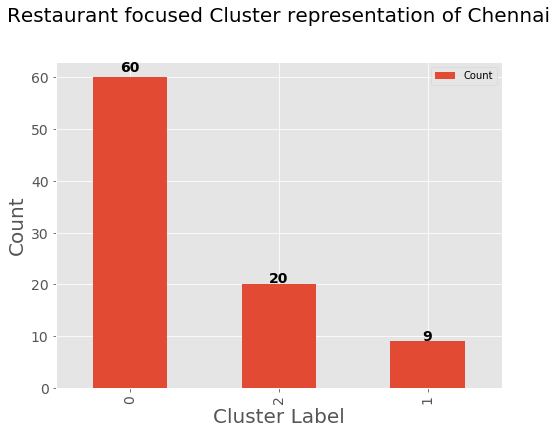

In [141]:
ax = label_count.plot(kind='bar',x='Cluster', figsize=(8,6),fontsize=14)

plt.title('Restaurant focused Cluster representation of Chennai',fontsize=20, pad=40)
plt.xlabel('Cluster Label',fontsize=20)
plt.ylabel('Count',fontsize=20)

for patch in ax.patches:
    bl = patch.get_xy()
    x = 0.5 * patch.get_width() + bl[0]
    # change 0.92 to move the text up and down
    y = 1.02 * patch.get_height() + bl[1] 
    ax.text(x,y,"%d" %(patch.get_height()),
            ha='center', weight = 'bold',fontsize=14)
    
plt.show()

## Plotting the Clusters on a Folium map

In [142]:
#getting the chennai lat and long values
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
ch_latitude = location.latitude
ch_longitude = location.longitude
print('The geograpical coordinate of Chennai are {}, {}.'.format(ch_latitude, ch_longitude))

The geograpical coordinate of Chennai are 13.0801721, 80.2838331.


In [143]:
# create map
map_clusters = folium.Map(location=[ch_latitude-0.0150, ch_longitude], zoom_start=12)

# set color scheme for the clusters
rainbow = ['#000000','#0000A0','#FF4500' ]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_final['Latitude'], chennai_final['Longitude'], chennai_final['Location'], chennai_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1 Analysis

In [166]:
cluster_1 = chennai_final[chennai_final['Cluster Labels']==0].drop(columns=['Cluster Labels','Latitude','Longitude']).reset_index(drop=True)
cluster1_stats = cluster_1.describe(include='all')
cluster1_stats

,Location,Kids Population in %,Educated Population in %,Working Population in %,Population in %,Total Households in %,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,60,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60,60,60,60,60
unique,60,NaN,NaN,NaN,NaN,NaN,NaN,22,25,26,28,26
top,Teynampet,NaN,NaN,NaN,NaN,NaN,NaN,Indian Restaurant,Whisky Bar,Whisky Bar,Whisky Bar,Farmers Market
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,26,8,10,9,11
mean,NaN,9.342833,81.905667,39.477167,0.576833,0.552167,9.850000,NaN,NaN,NaN,NaN,NaN
std,NaN,1.098117,4.820146,2.649867,0.190303,0.192020,12.787474,NaN,NaN,NaN,NaN,NaN
min,NaN,5.880000,68.640000,33.470000,0.250000,0.230000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,8.820000,79.210000,37.412500,0.437500,0.417500,2.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,9.425000,83.195000,39.365000,0.540000,0.530000,4.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,9.930000,85.007500,41.087500,0.692500,0.657500,12.250000,NaN,NaN,NaN,NaN,NaN


## Cluster 2 analysis

In [167]:
cluster_2 = chennai_final[chennai_final['Cluster Labels']==1].drop(columns=['Cluster Labels','Latitude','Longitude']).reset_index(drop=True)
cluster2_stats = cluster_2.describe(include='all')
cluster2_stats

,Location,Kids Population in %,Educated Population in %,Working Population in %,Population in %,Total Households in %,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,9,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9,9,9,9,9
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,4,7,6,7,7
top,Kodambakkam,NaN,NaN,NaN,NaN,NaN,NaN,Indian Restaurant,Whisky Bar,Harbor / Marina,Farmers Market,Fast Food Restaurant
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,4,3,3,2,2
mean,NaN,10.393333,82.506667,39.235556,3.496667,3.586667,9.777778,NaN,NaN,NaN,NaN,NaN
std,NaN,0.779744,1.417780,1.133921,0.456755,0.463276,12.285945,NaN,NaN,NaN,NaN,NaN
min,NaN,9.290000,79.410000,37.670000,2.910000,2.970000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,9.780000,82.120000,38.040000,3.050000,3.150000,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,10.650000,82.570000,39.380000,3.680000,3.740000,3.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,10.820000,83.500000,39.690000,3.780000,3.950000,11.000000,NaN,NaN,NaN,NaN,NaN


## Cluster 3 analysis

In [168]:
cluster_3 = chennai_final[chennai_final['Cluster Labels']==2].drop(columns=['Cluster Labels','Latitude','Longitude']).reset_index(drop=True)
cluster3_stats = cluster_3.describe(include='all')
cluster3_stats

,Location,Kids Population in %,Educated Population in %,Working Population in %,Population in %,Total Households in %,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,20,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20,20,20,20,20
unique,20,NaN,NaN,NaN,NaN,NaN,NaN,9,14,15,12,12
top,Dr.Sathiyavanimuthu Nagar,NaN,NaN,NaN,NaN,NaN,NaN,Indian Restaurant,Whisky Bar,Harbor / Marina,Farmers Market,Fast Food Restaurant
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,11,6,4,5,5
mean,NaN,9.763000,81.196500,39.363000,1.695000,1.72650,10.950000,NaN,NaN,NaN,NaN,NaN
std,NaN,1.083494,4.540789,1.978147,0.415888,0.42249,15.118741,NaN,NaN,NaN,NaN,NaN
min,NaN,7.240000,71.580000,35.450000,1.140000,1.23000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,9.315000,77.882500,38.357500,1.335000,1.35750,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,9.720000,82.400000,39.275000,1.570000,1.67500,4.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,10.222500,84.550000,40.597500,1.952500,2.00250,17.000000,NaN,NaN,NaN,NaN,NaN


## Findings from the cluster<br>
•	Cluster 1 – Dense cluster, sparsely populated areas, high education population.<br>
•	Cluster 2 – Sparse cluster, densely populated areas, high kids population.<br>
•	Cluster 3 – Moderately dense cluster, moderately populated, high education population.<br><br>

